In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

# Pre-Trained Models
## Loading the Model

In [5]:
from keras.applications import VGG16
# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")

553467904/553467096 [==============================] - 4s 0us/step


In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

In [18]:
import os
os.chdir('Nvidia_Workshop')

In [19]:
!ls

05a_doggy_door.ipynb  doggy_door_images


(1200, 1800, 3)


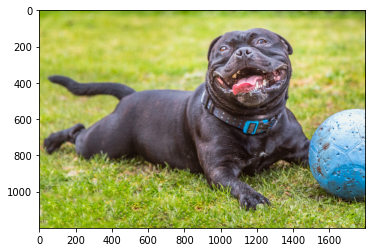

In [20]:
show_image("doggy_door_images/happy_dog.jpg")

## Preprocessing the Image

In [22]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

In [23]:
processed_image = load_and_process_image("doggy_door_images/brown_bear.jpg")

Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)


In [27]:
from tensorflow.keras.applications.vgg16 import decode_predictions

def readable_prediction(image_path):
    # Show image
    image=show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
40960/35363 [==================================] - 0s 0us/step
Predicted: [[('n02093256', 'Staffordshire_bullterrier', 0.45098063), ('n02110958', 'pug', 0.32263255), ('n02099712', 'Labrador_retriever', 0.09343204)]]


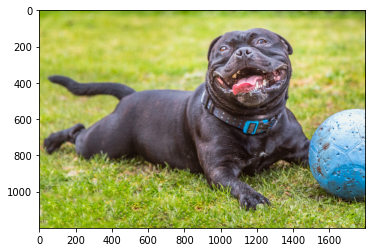

In [28]:
readable_prediction("doggy_door_images/happy_dog.jpg")

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02132136', 'brown_bear', 0.9853864), ('n02133161', 'American_black_bear', 0.013876137), ('n02410509', 'bison', 0.00026603576)]]


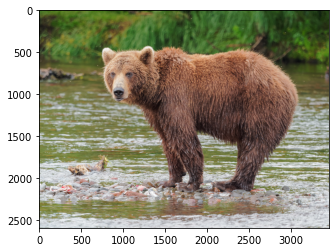

In [29]:
readable_prediction("doggy_door_images/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02123159', 'tiger_cat', 0.73654693), ('n02124075', 'Egyptian_cat', 0.1749267), ('n02123045', 'tabby', 0.045884065)]]


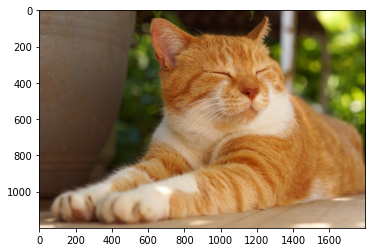

In [30]:
readable_prediction("doggy_door_images/sleepy_cat.jpg")

Now that we are making predictions with our model, we can use our categories to only let dogs in and out and keep cats inside. Remember that dogs are categories 151 through 268 and cats are categories 281 through 285. The np.argmax function can find which element of the prediction array is the top category

## Only Dogs

In [32]:
import numpy as np

def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    preds = model.predict(image)
    if 151 <= np.argmax(preds) <= 268:
        print("Doggy come on in!")
    elif 281 <= np.argmax(preds) <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)
You're not a dog! Stay outside!


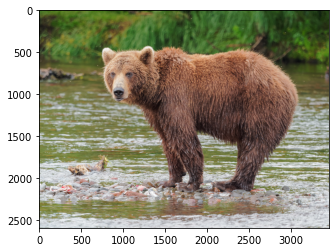

In [33]:
doggy_door("doggy_door_images/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Doggy come on in!


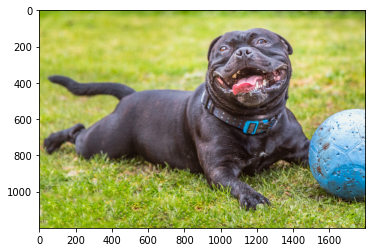

In [34]:
doggy_door("doggy_door_images/happy_dog.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Kitty stay inside!


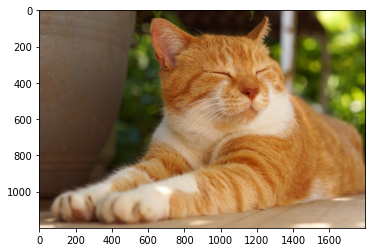

In [35]:
doggy_door("doggy_door_images/sleepy_cat.jpg")